## DGAZE: Driver Gaze Mapping on the Road

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

### Import Packages

In [3]:
import os
from load_dataset import *
from random import shuffle

import keras
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Merge, Dropout

from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from keras.regularizers import l1
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam, Adamax

from keras.models import model_from_yaml
import copy

In [4]:
## Utils functions

## Metadata
def get_metadata(__dict):
    keys = []
    for key, values in __dict.items():
        keys.append(key)
    return __dict, keys


def print_metadata(driver_data, metakeys):
    drivers_dict, drivers = get_metadata(driver_data)
    seq_dict, sequences = get_metadata(drivers_dict[drivers[0]])
    features_dict, features = get_metadata(seq_dict[sequences[0]])
    
    if 'drivers' in metakeys:
        print("List of Drivers: \n {}\n".format(drivers))
    if 'sequences' in metakeys:
        print("List of Sequences: \n {}\n".format(sequences))
    if 'features' in metakeys:
        print("List of Features: \n {}\n".format(features))
        
        
def get_dgaze_frames_count(driver_data, drivers):
    frames_count = 0
    for driver in drivers:
        data = driver_data[driver]
        frames_count += data['frames_count']
        print("Frames count for driver {} is {}".format(driver, data['frames_count']))
        
    print("\nTotal frames in DGAZE dataset is {}".format(frames_count))



# Split the dataset driver wise and points wise
def split_data(drivers, sequences, dsplit, gp_split):
    """
    Split the data into train-val and test based on number of drivers 
    dsplit = [driver_train_val, driver_test]
    
    Split the data into train, val and test based on number of unique points 
    gp_split = [gaze_point_train, gaze_point_val, gaze_point_test]
    """
    ## Split based on drivers
    drivers_train_val = drivers[:dsplit[0]]
    drivers_test = drivers[dsplit[0]:dsplit[0]+dsplit[1]]

    ## Split based on points
    seq_range = np.arange(0,sequences)
    shuffle(seq_range)
    points_train = seq_range[:gp_split[0]]
    points_val = seq_range[gp_split[0]:gp_split[0]+gp_split[1]]
    points_test = seq_range[gp_split[0]+gp_split[1]:gp_split[0]+gp_split[1]+gp_split[2]]
    
    return drivers_train_val, drivers_test, points_train, points_val, points_test
  
    
def load_data(driver_data, driver, points):
    gaze_point = None
    left_eye = None
    right_eye = None
    headpose_pupil = None
    face_location = None
    
   
    for ix in tqdm((points), position=0, leave=True):
 
        seq = "".join(['seq',str(ix+1)]) 
        
        if seq in driver_data[driver]:
            data = driver_data[driver]["".join(['seq',str(ix+1)])]
        
            if gaze_point is None:
                gaze_point = data['gaze_point']
                left_eye = data['left_eye']
                right_eye = data['right_eye']
                headpose_pupil = data['headpose_pupil']
                face_location = data['face_location']
            else:
                gaze_point = np.concatenate((gaze_point, data['gaze_point']),axis=0)
                left_eye = np.concatenate((left_eye, data['left_eye']),axis=0)
                right_eye = np.concatenate((right_eye, data['right_eye']),axis=0)
                headpose_pupil = np.concatenate((headpose_pupil, data['headpose_pupil']),axis=0)
                face_location = np.concatenate((face_location, data['face_location']),axis=0)
    return left_eye, right_eye, headpose_pupil, face_location, gaze_point


def dataset(drivers, points):
    dgaze_left_eye = None
    dgaze_right_eye = None
    dgaze_headpose_pupil = None
    dgaze_face_location = None
    dgaze_gaze_point = None

    for driver in tqdm((drivers), position=0, leave=True):
        left_eye, right_eye, headpose_pupil, face_location, gaze_point = load_data(driver_data, driver, points)

        if dgaze_left_eye is None:
            dgaze_left_eye = left_eye
            dgaze_right_eye = right_eye
            dgaze_headpose_pupil = headpose_pupil
            dgaze_face_location = face_location
            dgaze_gaze_point = gaze_point
        else:
            dgaze_left_eye = np.concatenate((dgaze_left_eye, left_eye),axis=0)
            dgaze_right_eye = np.concatenate((dgaze_right_eye, right_eye),axis=0)
            dgaze_headpose_pupil = np.concatenate((dgaze_headpose_pupil, headpose_pupil),axis=0)
            dgaze_face_location = np.concatenate((dgaze_face_location, face_location),axis=0)
            dgaze_gaze_point = np.concatenate((dgaze_gaze_point, gaze_point),axis=0)

    return dgaze_left_eye, dgaze_right_eye, dgaze_headpose_pupil, dgaze_face_location, dgaze_gaze_point

def save_model(model_name, model):
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open(model_name + '.yaml', "w") as yaml_file:
        yaml_file.write(model_yaml)
    # serialize weights to HDF5
    model.save_weights(model_name + ".h5")
    print("Saved model to disk")
    
def load_model(model_name):
    yaml_file = open(model_name + '.yaml', 'r')
    loaded_model_yaml = yaml_file.read()
    yaml_file.close()
    loaded_model = model_from_yaml(loaded_model_yaml)
    # load weights into new model
    loaded_model.load_weights(model_name + ".h5")
    print("Loaded model from disk")
    return loaded_model

### Load Dataset

In [5]:
data_path = '/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/'
drivers = os.listdir(data_path)
ndrivers = len(drivers)
frames_per_seq = 50
sequences = 112

driver_data = get_data(data_path, drivers, sequences, frames_per_seq)

#print_metadata(driver_data, ['features'])
#get_dgaze_frames_count(driver_data, drivers)

100%|██████████| 20/20 [00:27<00:00,  1.44s/it]


### Dataset split

In [6]:
dsplit = [15,5]
gp_split = [72,20,20]
drivers_train_val, drivers_test, points_train, points_val, points_test = \
                                    split_data(drivers, sequences, dsplit, gp_split)
print("For train points")
train_left_eye, train_right_eye, train_headpose_pupil, train_face_location, train_gaze_point = dataset(drivers_train_val, points_train)

print("For val points")
val_left_eye, val_right_eye, val_headpose_pupil, val_face_location, val_gaze_point = dataset(drivers_train_val, points_val)

print("For test points")
test_left_eye, test_right_eye, test_headpose_pupil, test_face_location, test_gaze_point =dataset(drivers_train_val, points_test)

print("For test drivers")
dtest_left_eye, dtest_right_eye, dtest_headpose_pupil, dtest_face_location, dtest_gaze_point = dataset(drivers_test, np.arange(0,sequences))


 14%|█▍        | 10/72 [00:00<00:00, 77.52it/s]

For train points


 60%|██████    | 12/20 [00:00<00:00, 100.82it/s]

For val points


 55%|█████▌    | 11/20 [00:00<00:00, 82.96it/s]

For test points


 11%|█         | 12/112 [00:00<00:00, 112.47it/s]

For test drivers


100%|██████████| 5/5 [01:54<00:00, 23.57s/it]


In [7]:
print(train_left_eye.shape, train_right_eye.shape, train_headpose_pupil.shape, train_face_location.shape, train_gaze_point.shape 
)
print(val_left_eye.shape, val_right_eye.shape, val_headpose_pupil.shape, val_face_location.shape, val_gaze_point.shape)
print(test_left_eye.shape, test_right_eye.shape, test_headpose_pupil.shape, test_face_location.shape, test_gaze_point.shape)
print(dtest_left_eye.shape, dtest_right_eye.shape, dtest_headpose_pupil.shape, dtest_face_location.shape, dtest_gaze_point.shape)

(108160, 36, 60, 3) (108160, 36, 60, 3) (108160, 11) (108160, 4) (108160, 6)
(29587, 36, 60, 3) (29587, 36, 60, 3) (29587, 11) (29587, 4) (29587, 6)
(31691, 36, 60, 3) (31691, 36, 60, 3) (31691, 11) (31691, 4) (31691, 6)
(57740, 36, 60, 3) (57740, 36, 60, 3) (57740, 11) (57740, 4) (57740, 6)


In [8]:
train_range = np.arange(0, train_gaze_point.shape[0])
val_range = np.arange(0, val_gaze_point.shape[0])
test_range = np.arange(0, test_gaze_point.shape[0])

shuffle(train_range)
shuffle(val_range)
shuffle(test_range)

train_left_eye, train_right_eye, train_headpose_pupil, train_face_location, train_gaze_point = \
    train_left_eye[train_range], train_right_eye[train_range], train_headpose_pupil[train_range], train_face_location[train_range], train_gaze_point[train_range]
    
val_left_eye, val_right_eye, val_headpose_pupil, val_face_location, val_gaze_point = \
    val_left_eye[val_range], val_right_eye[val_range], val_headpose_pupil[val_range], val_face_location[val_range], val_gaze_point[val_range]
    
test_left_eye, test_right_eye, test_headpose_pupil, test_face_location, test_gaze_point = \
    test_left_eye[test_range], test_right_eye[test_range], test_headpose_pupil[test_range], test_face_location[test_range], test_gaze_point[test_range]

In [8]:
import matplotlib.patches as patches

def plot_gaze_points(gaze_point):
    cap = cv2.VideoCapture(data_path + 'user12/original_road_view/sample_56.avi')
    ret, frame = cap.read()
    
    y = np.where(gaze_point[:,0]>=1920)
    gaze_point[y[0], 0]=1919
    y = np.where(gaze_point[:,0]<0)
    gaze_point[y[0],0]=0
    y = np.where(gaze_point[:,1]>=1080)
    gaze_point[y[0], 1]=1080
    y = np.where(gaze_point[:,1]<0)
    gaze_point[y[0], 1]=0

    plt.figure()
    plt.imshow(frame)
    plt.scatter(gaze_point[:,0], gaze_point[:,1], c='r')


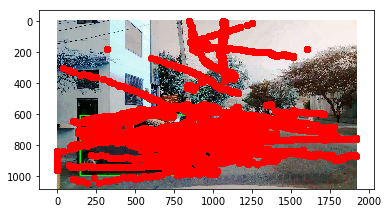

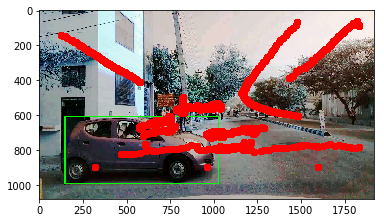

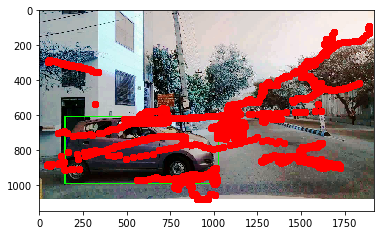

In [9]:
plot_gaze_points(train_gaze_point)
plot_gaze_points(val_gaze_point)
plot_gaze_points(test_gaze_point)

### I-DGAZE: Predicting driver gaze on road

In [1]:
model1 = Sequential()
model1.add(Conv2D(20, kernel_size=(5,5),activation='relu',input_shape=(36,60,3)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))
model1.add(Conv2D(50, (5,5), activation='relu',kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))
model1.add(Flatten())
model1.add(Dense(500, activation='relu', kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)))
# model1.add(Dense(128, activation='relu', kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)))

model2 = Sequential()
model2.add(Dense(100, activation ='relu', input_dim=(14)))
model2.add(Dense(32, activation ='relu'))

model3 = Sequential()
model3.add(Merge([model1, model2], mode = 'concat'))
# model3.add(Dense(1024, activation='relu', kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)))
# model3.add(Dense(128, activation='relu', kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)))
model3.add(Dense(32, activation='relu', kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)))
#model3.add(Dense(500))
model3.add(Dense(2))
model1.summary(), model2.summary(), model3.summary()

NameError: name 'Sequential' is not defined

In [13]:
from sklearn import preprocessing
train_face_features = np.concatenate((train_headpose_pupil[:,[1,2,3,4,5,6,7,8,9,10]],train_face_location[:]), axis =1)
val_face_features = np.concatenate((val_headpose_pupil[:,[1,2,3,4,5,6,7,8,9,10]],val_face_location[:]), axis =1)
test_face_features = np.concatenate((test_headpose_pupil[:,[1,2,3,4,5,6,7,8,9,10]],test_face_location[:]), axis =1)

mm_scaler = preprocessing.MinMaxScaler()
train_face_features = mm_scaler.fit_transform(train_face_features)
val_face_features = mm_scaler.transform(val_face_features)
test_face_features = mm_scaler.transform(test_face_features)

train_left_eye = train_left_eye/255
val_left_eye = val_left_eye/255
test_left_eye = test_left_eye/255



In [14]:

mc = keras.callbacks.ModelCheckpoint('weights_points_normalized_both/weights{epoch:04d}.h5', 
                                     save_weights_only=True, period=1)
# model_name = "weights/model1"
opt = Adam(lr=0.00001)

model3.compile(loss='mae', optimizer='adam')
earlystopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 1, patience =10, verbose =0, mode ='auto')

history = model3.fit([train_left_eye, train_face_features], train_gaze_point[:,:2], \
                      validation_data=([val_left_eye, val_face_features],val_gaze_point[:,:2]),\
                     epochs=300, batch_size=40, callbacks=[earlystopping], verbose=1, shuffle= True)
print(history.history.keys())

# save_model(model_name, model3)

Train on 108160 samples, validate on 29587 samples
Epoch 1/300
108160/108160 [==============================] - 51s 468us/step - loss: 203.1828 - val_loss: 232.4324
Epoch 2/300
108160/108160 [==============================] - 44s 408us/step - loss: 187.6347 - val_loss: 233.2105
Epoch 3/300
108160/108160 [==============================] - 44s 405us/step - loss: 186.0242 - val_loss: 231.0091
Epoch 4/300
108160/108160 [==============================] - 43s 401us/step - loss: 185.0248 - val_loss: 230.8988
Epoch 5/300
108160/108160 [==============================] - 43s 397us/step - loss: 184.4433 - val_loss: 230.7785
Epoch 6/300
108160/108160 [==============================] - 43s 401us/step - loss: 184.0138 - val_loss: 230.5279
Epoch 7/300
108160/108160 [==============================] - 43s 400us/step - loss: 183.5898 - val_loss: 232.0984
Epoch 8/300
108160/108160 [==============================] - 44s 404us/step - loss: 183.1046 - val_loss: 228.3495
Epoch 9/300
108160/108160 [==========

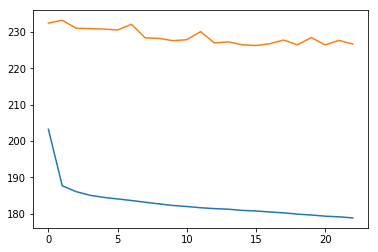

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [16]:
def gaze_error(left_eye, face_features, gaze_point):
    scores = model3.evaluate([left_eye, face_features], gaze_point)
    return scores

In [17]:
train_error = gaze_error(train_left_eye, train_face_features, train_gaze_point[:,:2])
val_error = gaze_error(val_left_eye, val_face_features, val_gaze_point[:,:2])
test_error = gaze_error(test_left_eye, test_face_features, test_gaze_point[:,:2])
    
print("Train Error ==> ", train_error)
print("Val Error ==> ",  val_error)
print("Test Error ==> " ,test_error)

31691/31691 [==============================] - 5s 152us/step
Train Error ==>  179.30709792368512
Val Error ==>  226.63101882565826
Test Error ==>  237.89257183052683


## Plot output